## 프로젝트 - Movielens 영화 추천 실습

#### 배경
- MF 모델을 토대로 영화 추천 시스템 제작

#### 데이터셋 관련 주의사항
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

### 1) 데이터 준비와 전처리
------

In [1]:
import os
import pandas as pd
import numpy as np
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
print(original_data_size)

1000209


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts'][:10]

0    5
1    3
2    3
3    4
4    5
5    3
6    5
7    5
8    4
9    4
Name: counts, dtype: int64

In [6]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(f'len(ratings) : {len(ratings)}')
print(f'len(movies) : {len(movies)}')

len(ratings) : 836478
len(movies) : 3883


> #### note:
> - 전처리 후 현재 갖고 있는 데이터는 두 가지 DataFrame이다.
> - 첫번째는 약 83만개의 영화별 rating(여기서는 재생 횟수로 여길 예정)을 나타내는 표 형태의 데이터이고,
> - 두번째는 약 4천개의 영화별 제목 및 장르 표 데이터 이다.
> #### 해당 데이터들을 통해 `유저 <-> 영화` 선호도 관계가 나올 수 있는 Matrix Factorization을 만들고, 이를 통해 추천 시스템을 만들어보자

### 2) 데이터 분석
----
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

#### - 데이터 전반에 대한 정보 확인

In [9]:
ratings.describe()

,user_id,movie_id,counts,timestamp
count,836478.000000,836478.000000,836478.000000,8.364780e+05
mean,3033.120626,1849.099114,3.958293,9.721628e+08
std,1729.255651,1091.870094,0.762280,1.206216e+07
min,1.000000,1.000000,3.000000,9.567039e+08
25%,1531.000000,1029.000000,3.000000,9.652795e+08
50%,3080.000000,1747.000000,4.000000,9.728388e+08
75%,4485.000000,2763.000000,5.000000,9.752064e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    836478 non-null  int64
 1   movie_id   836478 non-null  int64
 2   counts     836478 non-null  int64
 3   timestamp  836478 non-null  int64
dtypes: int64(4)
memory usage: 31.9 MB


> - `timestamp`라는 컬럼이 눈에 띈다.
> - 아마도 언제 평점을 매겼는지에 대한 데이터 같은데, 나중에 나의 취향 리스트를 추가할 때 대략적으로 비슷하게 넣으면 되겠다.

In [11]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


> - `movies` df는 텍스트 정보를 주로 담고 있는 것이 보인다.

#### - 결측치 유무 확인

In [13]:
ratings.isnull().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
dtype: int64

In [14]:
movies.isnull().sum()

movie_id    0
title       0
genre       0
dtype: int64

#### - ratings에 있는 unique 영화 개수

In [15]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [16]:
num_movie_rated = ratings['movie_id'].nunique()
print(num_movie_rated)

3628


#### - ratings에 있는 unique 사용자 수

In [17]:
num_user_rating = ratings['user_id'].nunique()
print(num_user_rating)

6039


#### - 가장 인기 있는 영화 30개
- `movie_id`별 `counts` sum으로 나타내기

In [18]:
best_30 = ratings.groupby('movie_id')['counts'].sum().sort_values(ascending=False)[:30]
best_30

movie_id
2858    14449
260     13178
1196    12648
2028    11348
1210    11303
1198    11179
593     11096
2571    10903
2762    10703
589     10513
608     10465
527     10317
110     10125
318     10085
1270    10081
858      9965
1197     9866
480      9601
1617     9515
2396     9503
1580     9057
296      9053
2997     8964
1265     8727
1097     8696
356      8679
1240     8571
1        8475
2716     8282
1214     8244
Name: counts, dtype: int64

In [19]:
# movie title과 함께 df로 만들어서 확인해보자
best_30_df = pd.merge(best_30, movies, on='movie_id').rename(columns={'user_id':'counts'})
print(f'len(best_30_df) : {len(best_30_df)}')
best_30_df.head()

len(best_30_df) : 30


,movie_id,counts,title,genre
0,2858,14449,American Beauty (1999),Comedy|Drama
1,260,13178,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1196,12648,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
3,2028,11348,Saving Private Ryan (1998),Action|Drama|War
4,1210,11303,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War


In [20]:
# 위의 merge 가 제대로 됐는지 샘플로 확인
print(movies.loc[movies['movie_id'] == 2858, 'title'])
print(movies.loc[movies['movie_id'] == 260, 'title'])
print(ratings.loc[ratings['movie_id'] == 2858, 'counts'].sum())
print(ratings.loc[ratings['movie_id'] == 260, 'counts'].sum())

2789    American Beauty (1999)
Name: title, dtype: object
257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object
14449
13178


> **best_30 영화들의 대략적인 장르가 궁금하다. 한번 장르별 수를 파악해보자(한 영화에 있는 모든 장르 포함)**

In [21]:
best_30_df['genre'].values

array(['Comedy|Drama', 'Action|Adventure|Fantasy|Sci-Fi',
       'Action|Adventure|Drama|Sci-Fi|War', 'Action|Drama|War',
       'Action|Adventure|Romance|Sci-Fi|War', 'Action|Adventure',
       'Drama|Thriller', 'Action|Sci-Fi|Thriller', 'Thriller',
       'Action|Sci-Fi|Thriller', 'Crime|Drama|Thriller', 'Drama|War',
       'Action|Drama|War', 'Drama', 'Comedy|Sci-Fi', 'Action|Crime|Drama',
       'Action|Adventure|Comedy|Romance', 'Action|Adventure|Sci-Fi',
       'Crime|Film-Noir|Mystery|Thriller', 'Comedy|Romance',
       'Action|Adventure|Comedy|Sci-Fi', 'Crime|Drama', 'Comedy',
       'Comedy|Romance', "Children's|Drama|Fantasy|Sci-Fi",
       'Comedy|Romance|War', 'Action|Sci-Fi|Thriller',
       "Animation|Children's|Comedy", 'Comedy|Horror',
       'Action|Horror|Sci-Fi|Thriller'], dtype=object)

In [22]:
from collections import Counter

best_30_genres = []
for combined_genre in best_30_df['genre'].values:
    best_30_genres.extend(combined_genre.split('|'))

c = Counter(best_30_genres)
c.most_common(len(set(best_30_genres)))

[('Action', 14),
 ('Drama', 11),
 ('Sci-Fi', 11),
 ('Comedy', 10),
 ('Thriller', 8),
 ('Adventure', 7),
 ('War', 6),
 ('Romance', 5),
 ('Crime', 4),
 ('Fantasy', 2),
 ("Children's", 2),
 ('Horror', 2),
 ('Film-Noir', 1),
 ('Mystery', 1),
 ('Animation', 1)]

> #### 'Action', 'Drama', 'Sci-Fi'... 'Comedy'도 높은 게 흥미롭다.
> - 혹시 가장 인기있는 영화를 groupby의 `sum`으로 하는 게 아니라 평균으로 하면 어떻게 될까?  
> => 생각해보니 이 경우엔 별로 재생횟수가 적은 영화임에도 높은 rating을 받았었다면 그 영화한테 유리하게 작동할 것 같다...

> #### 가장 최근 영화는 몇 년도 영화인지 궁금하다.

In [23]:
latest = 0
for title_year in movies.title.values:
    if latest <= int(title_year[-5:-1]):
        latest = int(title_year[-5:-1])

print(latest)

2000


### 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가하기
----------

- 영화를 즐겨본지가 오래됐다...
- 그런데 가장 최근 영화가 2000년에 개봉했으니... 그 이전에 개봉된 것으로 찾아봐야겠다.
> _**참고로 '데이터에 없는 영화를 넣으면 안될까?' 헷갈려서 머릿속으로 정리해보니, 그러면 sparse matrix 만들 때 다른 데이터가 하나도 없어서 어려울 것이다....**_

In [24]:
# 장르가 'Comedy|Drama'인 것 중 그나마 인기 있는 것들을 고를 예정이다.
pd.merge(movies[movies['genre'].isin(['Comedy|Drama'])], 
         ratings, 
         on='movie_id').groupby('title')['counts'].sum().sort_values(ascending=False)[:10]

title
American Beauty (1999)                        14449
Breakfast Club, The (1985)                     5773
Christmas Story, A (1983)                      5625
As Good As It Gets (1997)                      5435
Life Is Beautiful (La Vita è bella) (1997)     4898
Almost Famous (2000)                           4150
Cool Hand Luke (1967)                          3921
American Graffiti (1973)                       3905
League of Their Own, A (1992)                  3882
Player, The (1992)                             3783
Name: counts, dtype: int64

In [25]:
# 장르가 'Drama'인 것도 살펴보자
pd.merge(movies[movies['genre'].isin(['Drama'])], 
         ratings, 
         on='movie_id').groupby('title')['counts'].sum().sort_values(ascending=False)[:10]

title
Shawshank Redemption, The (1994)          10085
One Flew Over the Cuckoo's Nest (1975)     7496
Good Will Hunting (1997)                   6370
Amadeus (1984)                             5801
Fight Club (1999)                          5681
Rain Man (1988)                            5305
Apollo 13 (1995)                           5027
Erin Brockovich (2000)                     4921
Citizen Kane (1941)                        4821
Magnolia (1999)                            4102
Name: counts, dtype: int64

In [26]:
# 어떤 형식으로 추가해줘야 하는지 살펴보자
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [27]:
# user_id 할당
user_id = ['dj'] * 5

# 영화 타이틀로 할당
my_favourite = ['American Beauty (1999)' , 'Life Is Beautiful (La Vita è bella) (1997)' ,'Fight Club (1999)' ,'Man on the Moon (1999)' ,'Good Will Hunting (1997)']

# movie_id로 바꿔주기
my_favourite_id = [movies.loc[movies['title'] == title, 'movie_id'].values[0] for title in my_favourite]

# counts 할당
counts = [5] * 5

# timestamp 할당
timestamp = [978300760] * 5

# df로 만들기
my_watchlist = pd.DataFrame({'user_id':user_id,
                            'movie_id':my_favourite_id,
                             'counts':counts,
                            'timestamp':timestamp})

if not ratings.isin({'user_id':['dj']})['user_id'].any():
    ratings = ratings.append(my_watchlist)

ratings.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,dj,2858,5,978300760
1,dj,2324,5,978300760
2,dj,2959,5,978300760
3,dj,3174,5,978300760
4,dj,1704,5,978300760


In [28]:
ratings['user_id'].unique()

array([1, 2, 3, ..., 6039, 6040, 'dj'], dtype=object)

In [29]:
# 위의 텍스트 user_id를 변경해주자
mask = ratings['user_id'] == 'dj'
mask

0    False
1    False
2    False
3    False
4    False
     ...  
0     True
1     True
2     True
3     True
4     True
Name: user_id, Length: 836483, dtype: bool

In [30]:
# 6041이 혹시 있는지 확인
ratings.loc[ratings['user_id'] == 6041, :]

,user_id,movie_id,counts,timestamp


In [31]:
ratings.loc[mask, 'user_id'] = ratings.loc[mask, 'user_id'].map(lambda x : 6041)
ratings.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,6041,2858,5,978300760
1,6041,2324,5,978300760
2,6041,2959,5,978300760
3,6041,3174,5,978300760
4,6041,1704,5,978300760


### 4) CSR matrix 만들기
------

> #### note:
> - 현재 movie_id를 기준으로 엮을 수 있는 두 개의 테이블이 있다.
> - 이 중 어떤 걸 csr matrix 만드는 파라미터로 넣는 게 맞을까?
> - 우선 각각의 길이들을 확인해보자

In [32]:
print(ratings['movie_id'].nunique())
print(movies['movie_id'].nunique())
print(len(movies))

3628
3883
3883


> - `movies` 테이블에 등록된 영화의 개수가 rating된 영화의 개수보다 좀 더 많다.
> - 이 경우 `movies` 데이터를 쓰면 되지 않을까? 싶지만,
> - 한 번 시도해본 결과 `data`로 넣어주는 파라미터와 `row`, `col` 파라미터의 shape이 각각 맞아야 한단다.
> - 즉, `ratings` 데이터를 쓴다면 `col`의 개수도 데이터 파라미터인 `ratings`의 컬럼 개수랑 맞아야 한단다.

In [33]:
from scipy.sparse import csr_matrix

user_index_max = ratings['user_id'].max() + 1
movie_index_max = movies['movie_id'].max() + 1

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape=(user_index_max, movie_index_max))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

> #### note:
> - 이 분에서 csr_matrix를 만들 때 굉장히 헤맸다.
> - 결론적으로 `shape=()`파라미터에 어떤 수가 들어가냐의 문제인데, 그 수가 `row`, `col` 파라미터로 들어가는 데이터의 값보다 커야 한단다.(그 값을 인덱스로 보기 때문에)
> - 단순히 LMS 코드에서 변수명만 바꿔서는 안되는 것들이 있다.
> - 자세한 건 회고 부분에서 적어서 남겨야겠다.

### 5) als_model = AlternatingLeastSquares 모델 만들기
------

In [34]:
!pip install implicit

     |████████████████████████████████| 18.5 MB 25.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [35]:
# Implicit AlternatingLeastSquares 모델의 선언
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [36]:
# # als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
# csr_data_transpose = csr_data.T
# csr_data_transpose

In [37]:
# 모델 훈련
als_model.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

### 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악
------

> #### note:
> - 영화 타이틀`(str)` <-> 영화 id`(int)`로 바꿀 수 있어야 하는데,
> - 이는 `string_title` <-> `movies.loc[movies['title'] == string_title, 'movie_id'].values[0]` 방식으로 연결 관계를 삼아 찾을 예정

In [38]:
# 앞서 내가 좋아한다고 추가했던 영화 리스트의 타이틀을 살펴보자
my_favourite

['American Beauty (1999)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Fight Club (1999)',
 'Man on the Moon (1999)',
 'Good Will Hunting (1997)']

In [39]:
# 어떻게 구할 수 있는지 확인해보자
movies.loc[movies['title'] == my_favourite[0], 'movie_id'].values[0]

2858

In [40]:
movies.loc[movies['movie_id'] == 2858, 'title'].values[0]

'American Beauty (1999)'

In [41]:
# 함수화하기
def get_movie_id(title):
    return movies.loc[movies['title'] == title, 'movie_id'].values[0]

def get_movie_title(movie_id):
    return movies.loc[movies['movie_id'] == movie_id, 'title'].values[0]

In [42]:
# 확인해보기
get_movie_id(my_favourite[1])

2324

In [43]:
# 어떤 영화인지 타이틀로 나오도록 확인
print(get_movie_title(2324))
print(my_favourite[1])

Life Is Beautiful (La Vita è bella) (1997)
Life Is Beautiful (La Vita è bella) (1997)


#### - 해당 영화에 대한 나의 선호도 확인

In [44]:
# 내 user_id
dj_id = 6041

# 내가 좋아하는 movie_id
dj_movie_0 = get_movie_id(my_favourite[0])

# 두 개의 벡터 구하기
dj_vector, american_beauty_vector = als_model.user_factors[dj_id], als_model.item_factors[dj_movie_0]

In [45]:
# 내적해서 알아본 모델이 말하는 선호도는?
np.dot(dj_vector, american_beauty_vector)

0.6577313

In [47]:
# 다른 좋아하는 영화들의 내적 값은?
for i in range(1, 5):
    print(np.dot(dj_vector, als_model.item_factors[get_movie_id(my_favourite[i])]))

0.62059015
0.6105894
0.51550525
0.39076412


> #### feedback:
> - 나름 의미 있게 나오는 것 같다.
> - 그런데 왜 갈수록 그 수치가 떨어지는 걸까? `counts`는 분명히 다 같은 값으로 줬는데...

In [48]:
# 그렇다면 내가 좋아한다고 하지 않은 영화에 대해서는?

# 난수로 무작위 추출
random_movie_id = np.random.choice(movies['movie_id'].unique(), 1)[0]

# 단, 내가 좋아하는 영화 리스트에는 없어야 함
while True:
    if random_movie_id not in my_favourite_id:
        break
    else:
        random_movie_id = np.random.choice(movies['movie_id'].unique(), 1)[0]

print('랜덤으로 뽑은 영화와 점수는?')
print(f'영화 id : {random_movie_id}')
print(f'영화 제목 : {get_movie_title(random_movie_id)}')

# 해당 영화 벡터 할당
random_movie_vector = als_model.item_factors[random_movie_id]

# 내적하기
print(f'내적 점수 : {np.dot(dj_vector, random_movie_vector)}')

랜덤으로 뽑은 영화와 점수는?
영화 id : 2555
영화 제목 : Baby Geniuses (1999)
내적 점수 : -0.007186615839600563


In [49]:
# 그렇다면 내가 좋아한다고 하지 않은 영화에 대해서는?

# 난수로 무작위 추출
random_movie_id = np.random.choice(movies['movie_id'].unique(), 1)[0]

# 단, 내가 좋아하는 영화 리스트에는 없어야 함
while True:
    if random_movie_id not in my_favourite_id:
        break
    else:
        random_movie_id = np.random.choice(movies['movie_id'].unique(), 1)[0]

print('랜덤으로 뽑은 영화와 점수는?')
print(f'영화 id : {random_movie_id}')
print(f'영화 제목 : {get_movie_title(random_movie_id)}')

# 해당 영화 벡터 할당
random_movie_vector = als_model.item_factors[random_movie_id]

# 내적하기
print(f'내적 점수 : {np.dot(dj_vector, random_movie_vector)}')

랜덤으로 뽑은 영화와 점수는?
영화 id : 1396
영화 제목 : Sneakers (1992)
내적 점수 : -0.12202703952789307


> #### feedback:
> - 좋아하는 영화 리스트에 없는 영화들은 낮은 점수가 나온다.
> - 이로써 모델이 나름 괜찮게 학습된 것으로 보인다.

### 7) 내가 좋아하는 영화와 비슷한 영화를 추천받기
----
> - 기존에 할당해놓은 `my_favourite_id`를 토대로 해당 영화와 비슷하게 계산된 영화들 15개를 각각 뽑아보자 

In [64]:
# 한 번 5가지 영화 전부다 뽑아보자
df_list = []
for idx, movie_id in enumerate(my_favourite_id):
    similar_movies = als_model.similar_items(movie_id, N=15)
    similar_df = pd.DataFrame(similar_movies, index=['movie_id', 'preference']).T
    similar_df = pd.merge(similar_df, movies, on='movie_id') # title과 장르도 볼 수 있게 합치기
    similar_df['movie_id'] = similar_df['movie_id'].astype(int) # 실수형에서 정수형으로 바꿔줌
    df_list.append(similar_df)

print(len(df_list))

5


In [73]:
# 출력
from IPython.display import display

for idx, movie_id in enumerate(my_favourite_id):
    print()
    print(f'내가 좋아하는 영화 {get_movie_title(movie_id)}와 비슷한 영화들')
    display(df_list[idx])
    print('=====================================')


내가 좋아하는 영화 American Beauty (1999)와 비슷한 영화들


,movie_id,preference,title,genre
0,2858,1.000000,American Beauty (1999),Comedy|Drama
1,2997,0.729384,Being John Malkovich (1999),Comedy
2,2599,0.392312,Election (1999),Comedy
3,608,0.388648,Fargo (1996),Crime|Drama|Thriller
4,2396,0.368752,Shakespeare in Love (1998),Comedy|Romance
5,110,0.341175,Braveheart (1995),Action|Drama|War
6,296,0.334938,Pulp Fiction (1994),Crime|Drama
7,2706,0.322778,American Pie (1999),Comedy
8,2762,0.315799,"Sixth Sense, The (1999)",Thriller
9,3481,0.312401,High Fidelity (2000),Comedy



내가 좋아하는 영화 Life Is Beautiful (La Vita è bella) (1997)와 비슷한 영화들


,movie_id,preference,title,genre
0,2324,1.000000,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama
1,1873,0.418039,"Misérables, Les (1998)",Drama
2,2359,0.405251,Waking Ned Devine (1998),Comedy
3,1641,0.391215,"Full Monty, The (1997)",Comedy
4,3178,0.363197,"Hurricane, The (1999)",Drama
5,1784,0.353873,As Good As It Gets (1997),Comedy|Drama
6,1446,0.351347,Kolya (1996),Comedy
7,73,0.346007,"Misérables, Les (1995)",Drama|Musical
8,249,0.335981,Immortal Beloved (1994),Drama|Romance
9,2494,0.301225,"Last Days, The (1998)",Documentary



내가 좋아하는 영화 Fight Club (1999)와 비슷한 영화들


,movie_id,preference,title,genre
0,2959,1.000000,Fight Club (1999),Drama
1,3053,0.472183,"Messenger: The Story of Joan of Arc, The (1999)",Drama|War
2,2712,0.469945,Eyes Wide Shut (1999),Drama
3,3174,0.455499,Man on the Moon (1999),Comedy|Drama
4,778,0.443981,Trainspotting (1996),Drama
5,2997,0.435858,Being John Malkovich (1999),Comedy
6,2976,0.421573,Bringing Out the Dead (1999),Drama|Horror
7,2329,0.408689,American History X (1998),Drama
8,2762,0.407616,"Sixth Sense, The (1999)",Thriller
9,1060,0.387455,Swingers (1996),Comedy|Drama



내가 좋아하는 영화 Man on the Moon (1999)와 비슷한 영화들


,movie_id,preference,title,genre
0,3174,1.000000,Man on the Moon (1999),Comedy|Drama
1,2976,0.522091,Bringing Out the Dead (1999),Drama|Horror
2,2502,0.483354,Office Space (1999),Comedy|Romance
3,3078,0.460145,Liberty Heights (1999),Drama
4,3081,0.460098,Sleepy Hollow (1999),Horror|Romance
5,2959,0.455499,Fight Club (1999),Drama
6,3156,0.429624,Bicentennial Man (1999),Comedy|Drama|Sci-Fi
7,2480,0.420952,Dry Cleaning (Nettoyage à sec) (1997),Drama
8,2712,0.419020,Eyes Wide Shut (1999),Drama
9,3186,0.404812,"Girl, Interrupted (1999)",Drama



내가 좋아하는 영화 Good Will Hunting (1997)와 비슷한 영화들


,movie_id,preference,title,genre
0,1704,1.000000,Good Will Hunting (1997),Drama
1,318,0.652178,"Shawshank Redemption, The (1994)",Drama
2,150,0.621048,Apollo 13 (1995),Drama
3,1682,0.616245,"Truman Show, The (1998)",Drama
4,36,0.564591,Dead Man Walking (1995),Drama
5,778,0.526730,Trainspotting (1996),Drama
6,1393,0.516666,Jerry Maguire (1996),Drama|Romance
7,296,0.509649,Pulp Fiction (1994),Crime|Drama
8,3105,0.509105,Awakenings (1990),Drama
9,529,0.476235,Searching for Bobby Fischer (1993),Drama


### 8) 내가 가장 좋아할 만한 영화들을 추천받기
------

In [86]:
# 추천받기
dj = 6041
recommended_films = als_model.recommend(dj, csr_data[dj], N=20, filter_already_liked_items=True)
recommended_films

(array([2997, 2762, 1784, 3147,  296, 2599, 2396,  318, 2028, 3148, 3006,
        3052, 1747, 2712,  608,  593,  223,  527, 2336,  529], dtype=int32),
 array([0.54942507, 0.38596654, 0.32240593, 0.30313098, 0.27766013,
        0.2757269 , 0.2703993 , 0.26856425, 0.25413796, 0.2482866 ,
        0.24129009, 0.24007249, 0.23403409, 0.23107307, 0.22632463,
        0.22502622, 0.22326908, 0.22035521, 0.21004151, 0.20382118],
       dtype=float32))

In [90]:
# df 형태로 만들어서 영화 정보 확인하기
recommended_df = pd.DataFrame(recommended_films, index=['movie_id', 'preference']).T
recommended_df = pd.merge(recommended_df, movies, on='movie_id')
recommended_df['movie_id'] = recommended_df['movie_id'].astype(int)

recommended_df

,movie_id,preference,title,genre
0,2997,0.549425,Being John Malkovich (1999),Comedy
1,2762,0.385967,"Sixth Sense, The (1999)",Thriller
2,1784,0.322406,As Good As It Gets (1997),Comedy|Drama
3,3147,0.303131,"Green Mile, The (1999)",Drama|Thriller
4,296,0.277660,Pulp Fiction (1994),Crime|Drama
5,2599,0.275727,Election (1999),Comedy
6,2396,0.270399,Shakespeare in Love (1998),Comedy|Romance
7,318,0.268564,"Shawshank Redemption, The (1994)",Drama
8,2028,0.254138,Saving Private Ryan (1998),Action|Drama|War
9,3148,0.248287,"Cider House Rules, The (1999)",Drama


> ### _Being John Malkovich...?_
>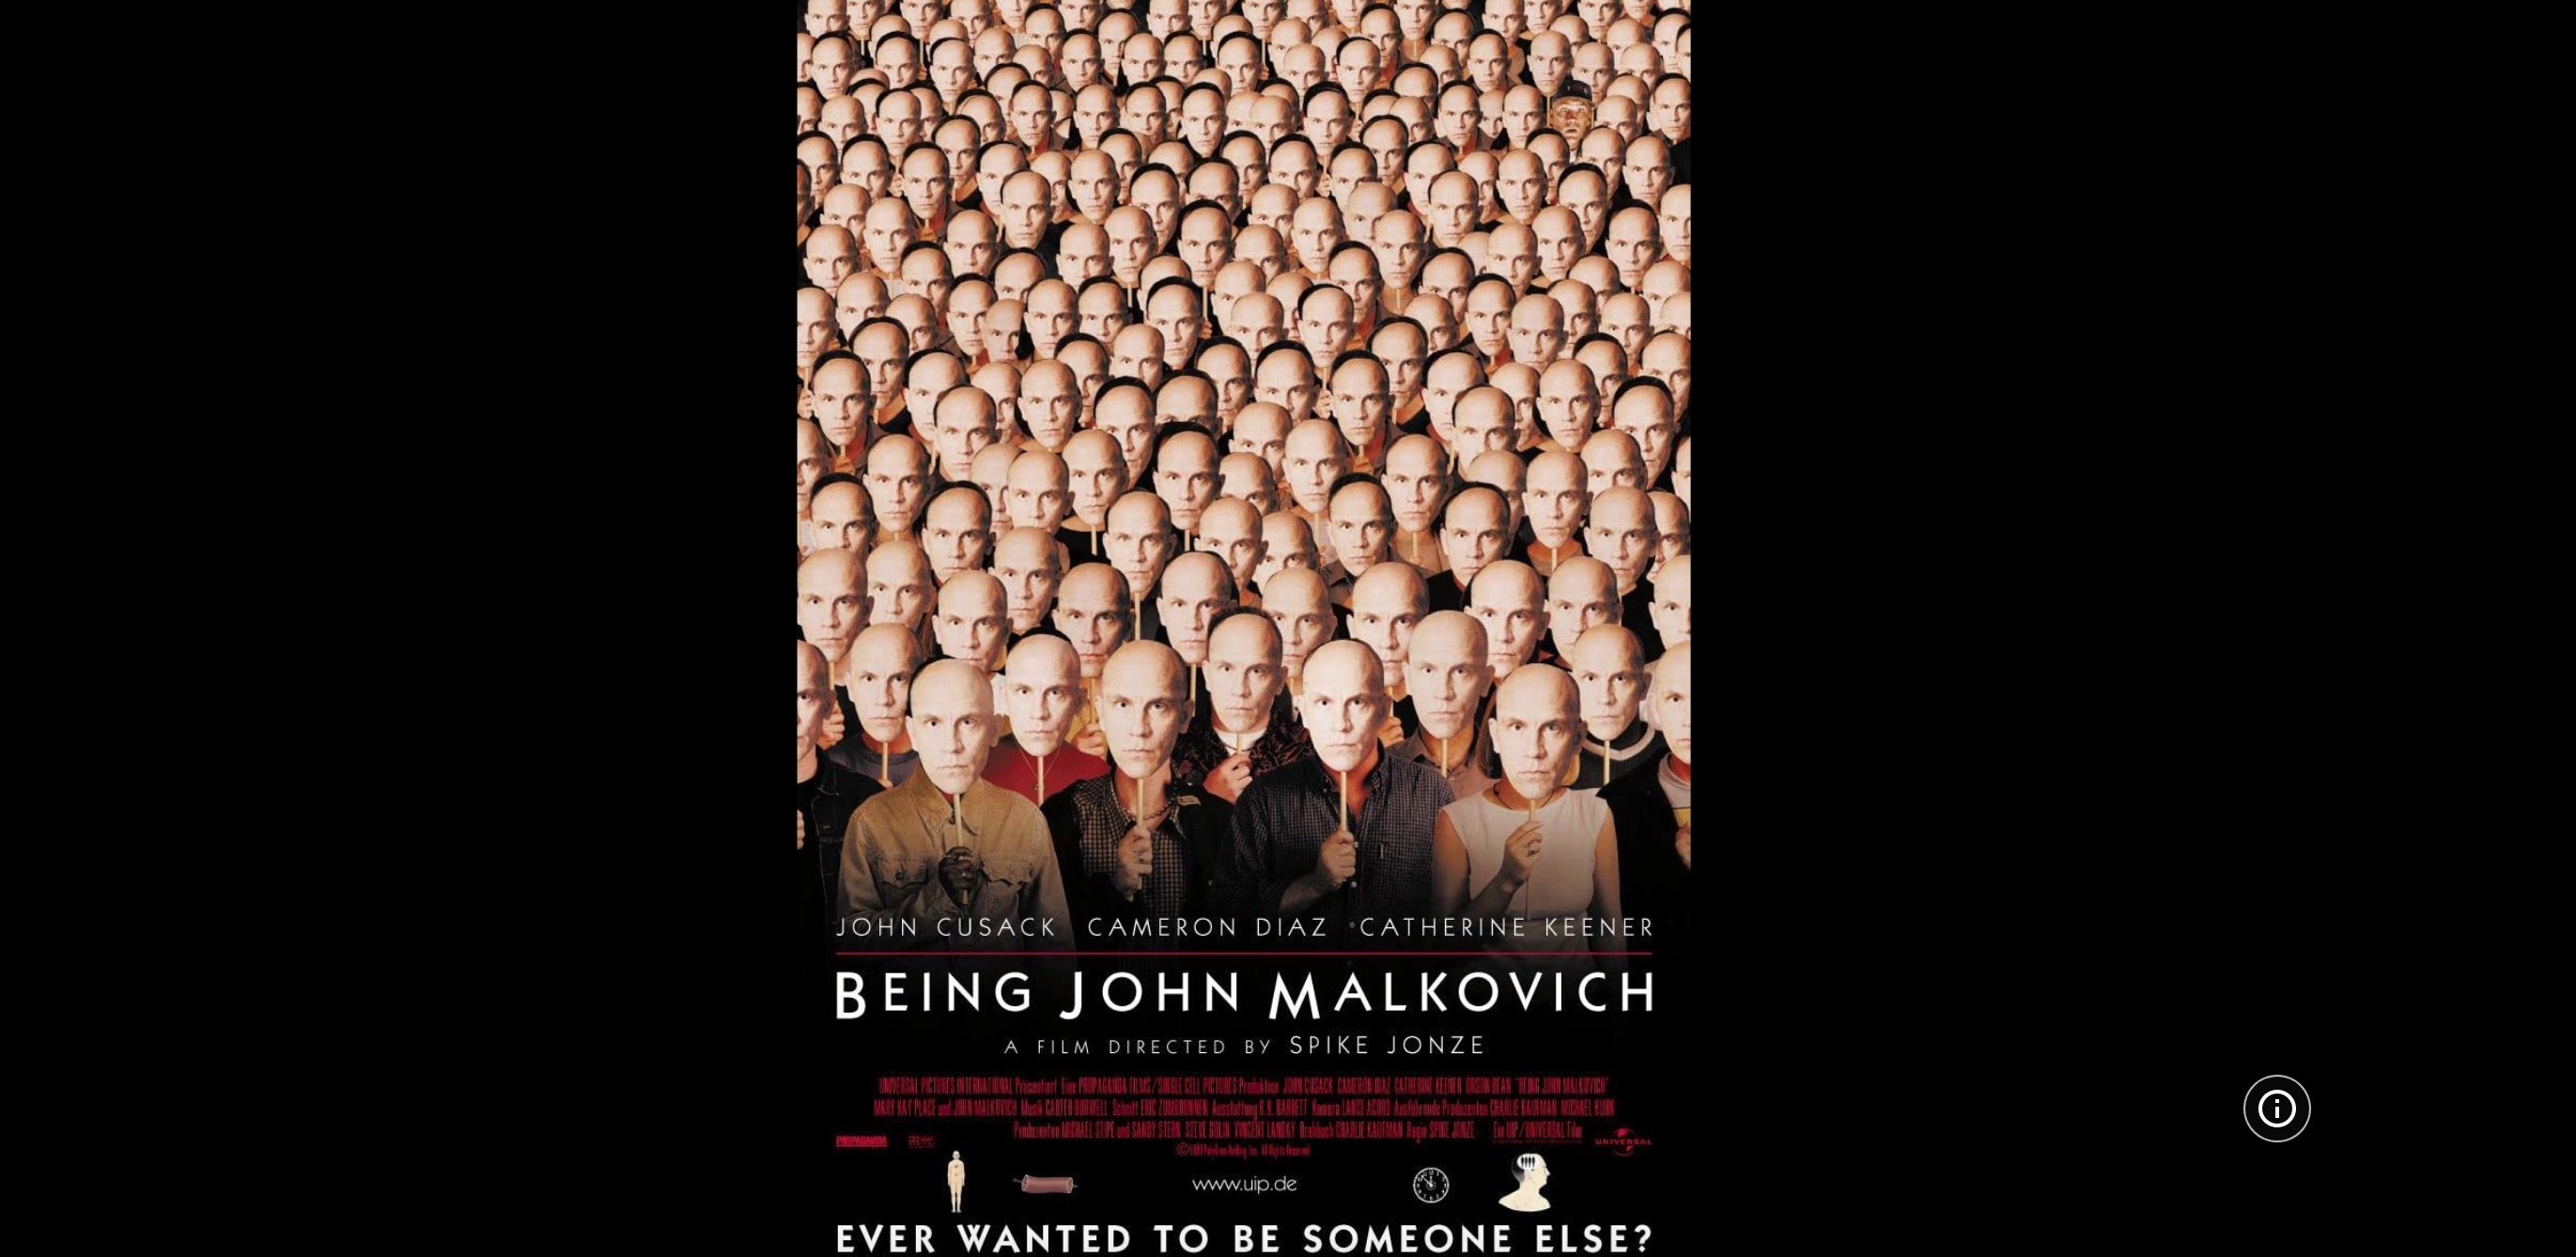

In [94]:
# 'Being John Malkovich'는 왜 추천해줬을까?
explained = als_model.explain(dj, csr_data, itemid=2997)

In [98]:
# 윗 영화 추천에 기여한 영화들의 선호도 총합
print(explained[0])

0.5376434283681049


In [99]:
# 어떤 영화들이 얼만큼 기여했을까?
explained_0 = {get_movie_title(tup[0]): tup[1] for tup in explained[1]}
explained_0

{'American Beauty (1999)': 0.3462970375140073,
 'Fight Club (1999)': 0.13000079139665088,
 'Man on the Moon (1999)': 0.08359929775470609,
 'Life Is Beautiful (La Vita è bella) (1997)': 0.020284525521604913,
 'Good Will Hunting (1997)': -0.04253822381886442}

> #### feedback:
> - 실습 때와 같이 이미 내 선호도에 있는 영화들이 포함되어서 기여한 것이 보인다.
> ##### 그렇기에 `implict` 라이브러리는 아직 많은 신뢰를 토대로 활용하기엔 역부족인 것 같다.

> #### 20개 중 실제로 좋아할까?
> - 사실 20개 영화 전부 다 알지 못하기에 정확한 `Mean Average Precision`을 구하는 것은 어려운 것 같다.
> - 다만, 그 중에 몇 개는 정말로 관심이 가는 영화들이다. (예 : 쇼생크탈출, 라이언일병구하기, 쉰들러리스트...)
> - 그러나, 역시 내가 절대 보지 않을 영화들도 있다. (예 : 펄프픽션, 식스센스... 무섭거나 징그러운 장면이 나오는 건 싫다...)
> - 어쩌면 이 부분은 `als_model` 생성시 `factors` 파라미터 개수에 따라 영향을 받을 수 있지 않을까 싶다.

## 회고
-----

#### Point 1) csr_matrix 생성 오류...
- `csr_matrix(data, (row, col), shaape=(M,N))`으로 만들 때 계속 오류가 났다.
- 오류는 `ValueError: row index exceeds matrix dimensions`인데, 도대체 뭐가 문제인지 찾을 수가 없었다.
- Scipy의 csr_matrix가 요구하는대로 data, row, col의 모양이 다 맞는데 뭐가 문제였을까 많이 헤맸다.
- https://stackoverflow.com/questions/46396450/sparse-matrix-valueerror-row-index-exceeds-matrix-dimensions 결국 여기에 있는 코멘트에서 약간의 힌트를 얻었고, 어쩜 `num_user`, `num_movie`가 현재 상식과는 다르게 row에 있는 unique한 value 갯수랑 다를 수도 있다는 생각이 들었다.
- 아래의 코드를 보자

> ```python
> from scipy.sparse import csr_matrix
> 
> num_user = ratings['user_id'].nunique() # >>> 6040
> num_movie = movies['movie_id'].nunique() # >>> 3883 
> 
> csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape=(num_user, num_movie))
> csr_data
> ```

- 언뜻 봐서는 문제될 게 없는 코드 같아 보이는데, 사실 num_user가 `6040`이란 것부터가 말이안되는 것이었다.(분명 6041로 나의 id를 추가했기에)
- 사실 여기서 오류가 나는 이유는 csr_matrix의 개발 시 조건으로 `ratings.user_id`에 있는 값들보다 더 큰 값이 num_user 자리에 와야하고,
- `ratings.movie_id`에 있는 값들보다 더 큰 값이 num_movie에 오게끔 설정해놓아서 그렇다.
- 이것은 각각의 값들을 index라고 전제해서 그런 것인데,
- 즉, movie_id가 0부터 3882까지 차근차근 있으면 저 코드가 문제가 안되는 것인데,
- 사실상 movie_id의 값은 차근차근 3882까지 있는 게 아니다.(**`ratings['movie_id'].max()`로 나오는 `3952`가 csr_matrix 입장에서는 맥시멈으로 잡아야하는 column 개수가 되는 것이다.**)   


- 번외로 아래의 코드는 초기에 num_user 값이 6041 대신 6040이 나온 게 의심돼서 '혹시나 빠진 번호가 있나?' 싶어서 찾아봤던 코드이다.
- 그런데 저렇게 나오는 이유가 더 이해 안 간다....

> ```python
> not_in = []
> real_in = []
> for i in range(1, 6042):
>     if i in ratings['user_id']:
>         real_in.append(i)
>     else:
>         not_in.append(i)
> 
> print(len(real_in))
> print(len(not_in))
> 
> >>> 5174
> >>> 867
> ```

#### Point 2) implicit 라이브러리의 불완전성
- 사실 실습 시 LMS에 있는 코드로는 계속해서 오류가 났다.(그냥 복사&붙여넣기 해서 주피터에 가져다 썼는데도 오류가 났다)
- 요약하면,  `als_model`에 넣는 csr_matrix의 종류와(user, item 모양인지 혹은 item, user 모양인지...) 나중에 `.recommend`할 때 넣어주는 인자값이 단순 csr_matrix가 아니었던 점이 계속해서 오류가 났었다.
- 이런 점은 사실 학습하는 측면에서 나름 debugging하는 훈련을 하게 해줘서 긍정적인 면도 있었지만, 한편으로는 '왜 나는 안되는 거지?' 라는 의구심에 실제 debugging보다는 내 코드가 맞는지 아닌지 등에 더 많은 시간을 쏟게 됐었고, 이런 점은 LMS 컨텐츠에 대한 아쉬움으로 남는다.
- 그래도 이번에는 `implicit`을 만든 사람의 github에 가서 패키지 코드를 이것 저것 찾아보고, 원리도 나름 이해하는 등의 경험이 쌓여서 긍정적인 면이 더 강했던 것 같다.

#### Point 3) 실제 추천시스템
- 오늘 학습한 추천 시스템은 Matrix Factorization만 어느 정도 이해하면 쉽게 실습할 수 있었던 듯하다.
- 하지만 실제 플랫폼 서비스에 이용되는 추천시스템을 생각해보자.
- 과연 저런 `평점` 하나만 갖고 MF 모델을 만들어서 사용할까?
- 언뜻 생각해봐도 이러저러한 지표들이 굉장히 많은데, 과연 해당 지표들을 어떻게 정리하고 연결시켜서 의미있는 예측 알고리즘을 만드는지가 궁금하다.
